In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformer_lens import HookedTransformer
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm

# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["http_proxy"] = "http://10.176.52.116:7890"
os.environ["https_proxy"] = "http://10.176.52.116:7890"

In [3]:
target_lang = 'zh'
latent_lang = 'en'
model_size = '7b'
model_name = 'qwen'
if model_name == 'qwen':
    # Qwen1.5-1.8b
    model_path = "/remote-home/fkzhu/.cache/huggingface/hub/models--Qwen--Qwen1.5-1.8B/snapshots/7846de7ed421727b318d6605a0bfab659da2c067/"
    model_name = 'Qwen/Qwen1.5-1.8B'
elif model_name == 'phi':
    # phi-2
    model_path = "/remote-home/fkzhu/models/phi-2"
    model_name = "microsoft/phi-2"

# # opt-2.7b
# model_path = "/remote-home/fkzhu/models/facebook/opt-2.7b"
# model_name = 'facebook/opt-2.7b'


# # Llama-2-7b-hf
# model_path = "/remote-home/fkzhu/models/Llama-2-7b-hf"
# model_name = "meta-llama/Llama-2-7b-hf"

# # gemma-2b
# model_path = "/remote-home/fkzhu/models/gemma-2b"
# model_name = "google/gemma-2b"

local_files_only = True
single_token_only = False
multi_token_only = False
out_dir = './visuals'
inference_dtype=torch.float32

In [4]:
prefix = "./data/langs/"
if target_lang == 'en':
    df_en_de = pd.read_csv(f'{prefix}{target_lang}/clean_for_en.csv')
else:
    df_en_de = pd.read_csv(f'{prefix}{target_lang}/clean.csv')

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=local_files_only, use_fast=False)
hf_model = AutoModelForCausalLM.from_pretrained(model_path, #load_in_8bit=True, 
                                                torch_dtype=inference_dtype,
                                             local_files_only=local_files_only)

model = HookedTransformer.from_pretrained(model_name,
                                          fold_ln=False,
                                          hf_model=hf_model)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/remote-home/fkzhu/anaconda3/envs/mech/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 172.00 MiB. GPU 0 has a total capacity of 23.65 GiB of which 78.56 MiB is free. Process 33742 has 23.57 GiB memory in use. Of the allocated memory 22.59 GiB is allocated by PyTorch, and 16.01 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
unemb = nn.Sequential(model.ln_final, model.unembed)
U = torch.transpose(list(unemb[1].parameters())[0],0,1).detach().cpu().float()
print(f'{list(unemb[0].parameters())=}')
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f"{weights=}")
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0) 
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())


list(unemb[0].parameters())=[Parameter containing:
tensor([5.0938, 4.8438, 4.9062,  ..., 5.0312, 4.9062, 4.8750], device='cuda:0',
       requires_grad=True)]
weights=tensor([5.0938, 4.8438, 4.9062,  ..., 5.0312, 4.9062, 4.8750])
U torch.Size([151936, 2048]) weights torch.Size([1, 2048])
0.0665488988161087


In [ ]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    print(f'{start_key=}')
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    print(f'{with_prefixes=}\n{with_spaces=}\n{with_capitalizations=}')
    final_tokens = []
    for tok in with_capitalizations:
        tok = tokenizer.convert_ids_to_tokens(tokenizer(tok)['input_ids'])
        print(f"{tok=}")
        if len(tok) == 1:
            tok = tok[0]
        else:
            continue
        if tok in tokenizer.get_vocab():
            print(f"In get_vocab()")
            final_tokens.append(tokenizer.get_vocab()[tok])
        else:
            print(f"Not In get_vocab()")
    if lang in ['zh', 'ru']:
        # token_str = tokenizer.convert_ids_to_tokens(tokenizer(token_str)['input_ids'])
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        print(f"{tokid=}")
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}

# Gap texts

In [ ]:
key = "blank_prompt_translation_masked"
dataset_gap = []
n_skip = 2

for idx, (idx_df, row) in tqdm(enumerate(df_en_de.iterrows())):
    print(row)
    prompt_template = f''
    indices = set(list(range(len(df_en_de)))) - set([idx])
    idx_examples = np.random.choice(list(indices), n_skip, replace=False)
    prompt_template += f'{df_en_de[key][idx_examples[0]]}\n'
    prompt_template += f'{df_en_de[key][idx_examples[1]]}\n' 

    # get tok sets and kick out if intersection
    out_token_str = row['word_translation']
    latent_token_str = row['word_original']
    out_token_id = process_tokens(out_token_str, tokenizer, target_lang)
    # out_token_id = tokenizer(out_token_str)['input_ids']
    print(f"{out_token_str=}")
    print(f"{out_token_id=}")
    latent_token_id = process_tokens(latent_token_str, tokenizer, latent_lang)
    # latent_token_id = tokenizer(latent_token_str)['input_ids']
    print(f"{latent_token_str=}")
    print(f"{latent_token_id=}")
    # if len(out_token_id) > 1 and out_token_id[0] == latent_token_id[0] and out_token_id != latent_token_id: 
    #     out_token_id = [out_token_id[1]]
    #     latent_lang = [latent_token_id[1]]
    intersection = set(out_token_id).intersection(set(latent_token_id))
    if len(out_token_id) == 0 or len(latent_token_id) == 0:
        continue
    if target_lang != 'en' and len(intersection) > 0:
        continue 
    if target_lang == 'zh':
        prompt = row[key].split("：")[0]+": \""
    else: 
        prompt = row[key].split(":")[0]+": \""
    dataset_gap.append({
        'prompt': prompt_template + prompt,
        'out_token_id': out_token_id,
        'out_token_str': out_token_str,
        'latent_token_id': latent_token_id,
        'latent_token_str': latent_token_str,
    })

In [ ]:
len(dataset_gap)

139

In [ ]:
df_gap = pd.DataFrame(dataset_gap)
print(df_gap['prompt'][0])

"_"是一种大型家养动物，有四条腿，常用于骑乘和赛跑。答案："马"。
"_"是夜空中发光的天体。答案："星"。
"_"用来阅读故事。答案: "


In [ ]:
df_gap

,prompt,out_token_id,out_token_str,latent_token_id,latent_token_str
0,"""_""是一种大型家养动物，有四条腿，常用于骑乘和赛跑。答案：""马""。\n""_""是夜空中发光的...",[90286],书,"[65, 32993, 2190, 749]",book
1,"""_""是火车或公共汽车定期停靠以便乘客上下车的地方。答案：""站""。\n""_""用来坐和休息。答...",[99718],云,"[12361, 564, 66, 32578]",cloud
2,"""_""是火车或公共汽车定期停靠以便乘客上下车的地方。答案：""站""。\n""_""是我们行走和建造...",[67279],包,"[65, 4645, 21250]",bag
3,"""_""是在八之后的数字。答案：""九""。\n""_""是被陆地包围的大片水体。答案：""湖""。\n""...",[39426],口,"[6355, 76, 32680]",mouth
4,"""_""是人中被视为道德上好或可取的品质。答案：""德""。\n""_""是在九百九十九之后的数值。答...",[72990],土,"[82, 704]",soil
...,...,...,...,...,...
134,"""_""是指向北的基本方向的相反方向。答案：""南""。\n""_""是传统社会中由家庭或社区通过社会...",[71618],起,"[461, 31509, 5963, 81]",rise
135,"""_""是覆盖地球大部分表面的大片盐水。答案：""洋""。\n""_""是通常用于阅读的平面物体。答案...",[77559],左,"[273, 59238, 2359, 75]",left
136,"""_""是一种艺术形式，涉及到身体的运动，通常是有节奏的并伴随音乐。答案：""舞""。\n""_""是...",[78685],音,"[27532, 82, 704]",sound
137,"""_""是自然形成的、足够人进入的地下空间。答案：""洞""。\n""_""用来连接被河流或道路等障碍...",[47534],力,"[13175, 5368, 79, 21743]",power


In [ ]:
os.makedirs(f'{os.path.join(out_dir, model_name)}/cloze', exist_ok=True)
df_gap.to_csv(f'{os.path.join(out_dir, model_name)}/cloze/{target_lang}_dataset.csv', index=False)

In [ ]:
latent_token_probs = []
out_token_probs = []
entropy = []
energy = [] 
latents_all = []
device = torch.device("cuda:0")

with torch.backends.cuda.sdp_kernel(enable_flash=False):
    for idx, d in tqdm(enumerate(dataset_gap)):
        last = []
        latents = []
        
        logits, cache = model.run_with_cache(model.to_tokens(d['prompt']), return_type='logits')
        latents = torch.cat([cache[f'blocks.{i}.hook_resid_post'] for i in range(len(model.blocks))])
        logits = unemb(latents)
        latents = latents.detach().cpu().clone().float()

        # latents = llama.latents_all_layers(d['prompt'])
        # logits = unemb(latents)
        last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
        latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
        out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
        entropy += [compute_entropy(last)]

        latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
        latents_normalized = latents[:, -1, :].float()

        latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
        latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
        norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
        energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

139it [00:37,  3.69it/s]


/remote-home/fkzhu/zfk/multilingual/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


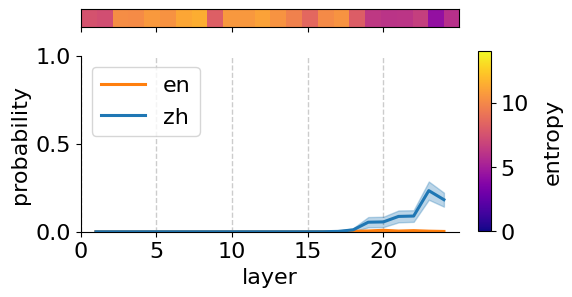

In [ ]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, latent_lang, color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True,
nums=[.99, 0.18, 0.025, 0.6])
plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{os.path.join(out_dir, model_name)}/cloze', exist_ok=True)
plt.savefig(f'{os.path.join(out_dir, model_name)}/cloze/{model_size}_{target_lang}_probas_ent.png', dpi=300, bbox_inches='tight')

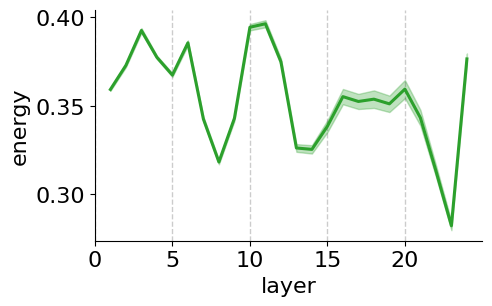

In [ ]:
fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{os.path.join(out_dir, model_name)}/cloze', exist_ok=True)
plt.savefig(f'{os.path.join(out_dir, model_name)}/cloze/{model_size}_{target_lang}_energy.png', dpi=300, bbox_inches='tight')

In [ ]:
torch.save(latents, f'{os.path.join(out_dir, model_name)}/cloze/{model_size}_{target_lang}_latents.pt')